In [2]:
%matplotlib inline

import json, glob, sys, os, gzip
from IPython.display import HTML
import ipywidgets
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from yahist import set_default_style, Hist1D, Hist2D
from tqdm.auto import tqdm

import uproot
import requests

In [8]:
df_nul = pd.read_csv("UL_Nevt_bphi_v0.csv")
# df_nul = df_nul[df_nul["mass"].isin([0.3, 0.4, 0.5, 0.6, 0.75, 1.0, 1.25, 1.5, 2.0, 2.5, 3.5, 4.0])][["mass", "ctau = 1", "ctau = 10", "ctau = 100"]]
df_nul = df_nul[df_nul["mass"].isin([0.5, 0.6, 0.75, 1.0, 1.25, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0])][["mass", "ctau = 1", "ctau = 10", "ctau = 100"]]
df_nul.columns = df_nul.columns.map(lambda x: x + "mm" if "ctau" in x else x)

Text(0.5, 1.0, 'UL on Nevents for 10fb${}^\\mathregular{-1}$')

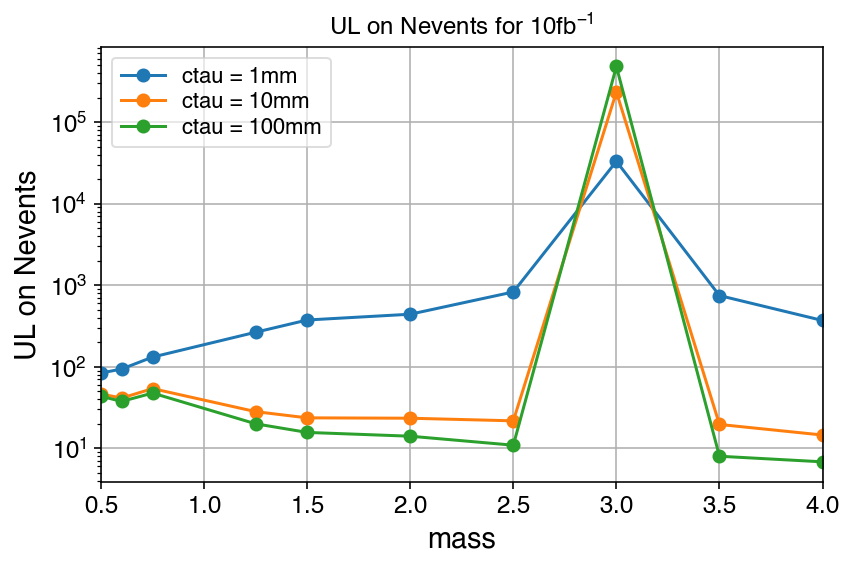

In [9]:
fig, ax = plt.subplots()

df_nul.set_index("mass").plot(ax=ax, marker="o")

ax.set_yscale("log")

ax.grid()
ax.set_ylabel("UL on Nevents")
ax.set_title(r"UL on Nevents for 10fb${}^\mathregular{-1}$")

In [10]:
df_nul

,mass,ctau = 1mm,ctau = 10mm,ctau = 100mm
0,0.50,83.838326,46.324531,43.436086
4,0.60,93.949167,41.332504,37.617426
10,0.75,131.516603,53.998276,47.609313
19,1.25,265.271393,28.179286,19.987940
20,1.50,374.558803,23.652900,15.675043
22,2.00,440.982774,23.405896,14.086600
24,2.50,826.844599,21.740544,10.925400
26,3.00,33046.964618,234399.062425,480619.095478
28,3.50,746.814236,19.631737,8.002987
30,4.00,369.538852,14.564365,6.832503


In [12]:
!mkdir -p ntuples
fnames = !ssh ucsd ls /hadoop/cms/store/user/namin/ProjectMetis/BToPhi_params_mphi{0p5,0p6,0p75,1p25,1p5,2,2p5,3,3p5,4}_ctau{1,10,100}mm_BABY_vtestfine2/*.root
for fname in fnames:
    newfname = "ntuples/output_" + fname.rsplit("/",2)[-2].split("params_")[1].split("_BABY")[0] + ".root"
    if os.path.exists(newfname): continue
    !scp ucsd:{fname} {newfname}

output_1.root                                 100% 1470KB   2.8MB/s   00:00    
output_1.root                                 100% 4006KB   4.7MB/s   00:00    
output_1.root                                 100% 7522KB  11.2MB/s   00:00    
output_1.root                                 100% 2300KB   3.4MB/s   00:00    
output_1.root                                 100% 5983KB  11.3MB/s   00:00    
output_1.root                                 100%   10MB   7.1MB/s   00:01    


In [20]:
# !curl -O https://raw.githubusercontent.com/claudiocc1/Bphi/master/results/weights_shapeOnly_2.8.txt
# !curl -O https://raw.githubusercontent.com/claudiocc1/Bphi/master/results/filter_efficiency_FONLL_shape.txt
!cp ~/sandbox/miscnotebooks/scouting/fonll/Bphi/results/weights_shapeOnly_2.8.txt .
!cp ~/sandbox/miscnotebooks/scouting/fonll/Bphi/results/filter_efficiency_FONLL_shape.txt .

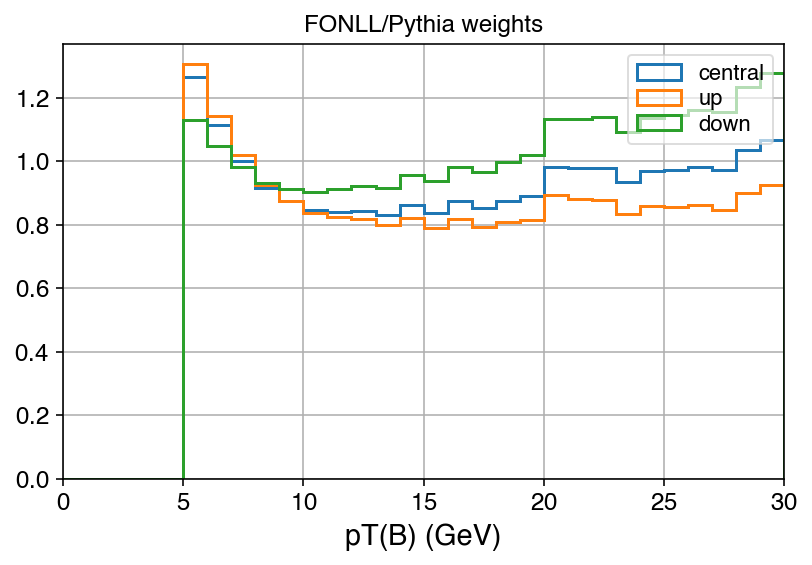

In [26]:
df_wpt = pd.read_csv("weights_shapeOnly_2.8.txt",
            sep=" ",
             skiprows=1,
             names=["pt","central","down","up","junk"],
           ).drop(["junk"],axis="columns")

bins = np.arange(101)
hists_wpt = dict()
for which in ["central","up","down"]:
    h = Hist1D.from_bincounts(df_wpt[which].values, bins=bins, errors=0.*df_wpt[which].values)
    h = Hist1D(h.restrict(0,30), label=which)
    hists_wpt[which] = h

fig, ax = plt.subplots()

for which,h in hists_wpt.items():
    h.plot(histtype="step", lw=1.5)

ax.set_xlabel("pT(B) (GeV)")
ax.set_title("FONLL/Pythia weights")
ax.grid()

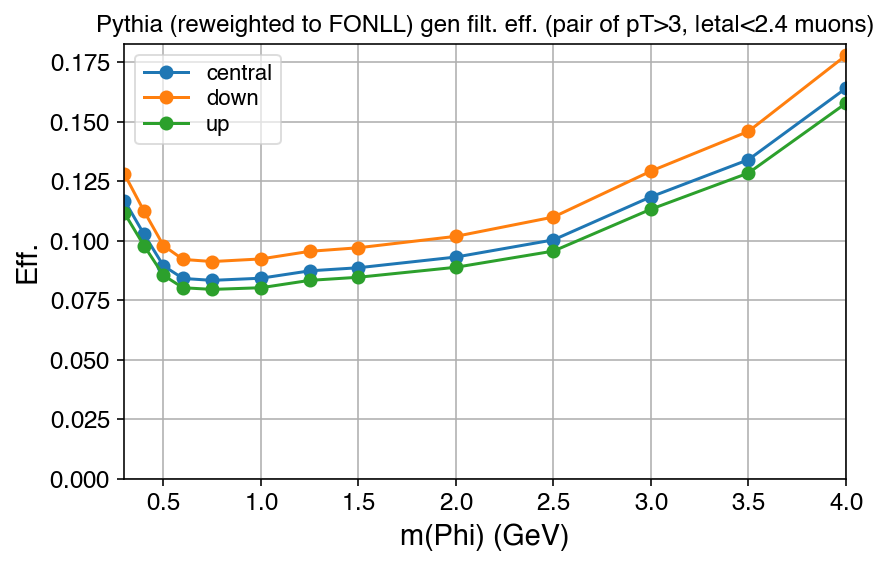

In [27]:
blocks = open("filter_efficiency_FONLL_shape.txt").read().split("\n\n")
data = []
for block in blocks:
    lines = block.strip().splitlines()
    d = {}
    for line in lines:
        parts = line.split()
        d["mass"] = float(parts[2])
        d[parts[5]] = float(parts[9])/100.
    data.append(d)
df_filteff = pd.DataFrame(data)
df_filteff

fig, ax = plt.subplots()
df_filteff.set_index("mass").plot(ax=ax, marker="o")
ax.set_xlabel("m(Phi) (GeV)")
ax.set_ylabel("Eff.")
ax.set_title("Pythia (reweighted to FONLL) gen filt. eff. (pair of pT>3, |eta|<2.4 muons)")
ax.set_ylim(bottom=0.)
ax.grid()

In [28]:
%%time

mass = 2.0
ctau = 10

smass = str(mass).replace(".","p").replace("p0","")
fname = f"ntuples/output_mphi{smass}_ctau{ctau}mm.root"
f = uproot.open(fname)

df_gen = f["btophitree"].pandas.df()
df_gen = df_gen[df_gen.eval("BToPhi_nphi==1 and BToPhi_bmesonpt>5 and abs(BToPhi_bmesoneta)<2.8")].reset_index(drop=True)
n0 = len(df_gen)

n1_wpt_central = hists_wpt["central"].lookup(df_gen["BToPhi_bmesonpt"]).sum()
n1_wpt_up = hists_wpt["up"].lookup(df_gen["BToPhi_bmesonpt"]).sum()
n1_wpt_down = hists_wpt["down"].lookup(df_gen["BToPhi_bmesonpt"]).sum()

epsgen_central = df_filteff[np.isclose(df_filteff["mass"],mass)]["central"].values[0]
epsgen_up = df_filteff[np.isclose(df_filteff["mass"],mass)]["up"].values[0]
epsgen_down = df_filteff[np.isclose(df_filteff["mass"],mass)]["down"].values[0]

print(epsgen_central)

df_gen

0.0931
CPU times: user 91.6 ms, sys: 12.9 ms, total: 104 ms
Wall time: 127 ms


,BToPhi_nphi,BToPhi_mu1pt,BToPhi_mu2pt,BToPhi_mu1eta,BToPhi_mu2eta,BToPhi_phimass,BToPhi_phipt,BToPhi_phieta,BToPhi_bmesonmass,BToPhi_bmesonid,BToPhi_bmesonpt,BToPhi_bmesoneta
0,1,6.656,5.441,-1.077,-0.958,1.999,11.954,-1.034,5.280,511,11.717000,-1.106
1,1,5.628,3.562,2.128,1.969,2.000,9.001,2.089,5.279,521,8.743000,2.192
2,1,4.274,4.052,-1.005,-1.472,2.001,8.318,-1.256,5.279,521,19.295000,-1.312
3,1,8.873,4.319,1.236,1.540,2.000,13.177,1.346,5.367,-531,16.030001,1.410
4,1,6.699,4.832,-0.522,-0.261,2.000,11.456,-0.419,5.279,-521,12.820000,-0.469
...,...,...,...,...,...,...,...,...,...,...,...,...
17744,1,3.907,3.700,0.809,0.300,1.992,7.601,0.578,5.279,521,9.665000,0.453
17745,1,3.989,3.266,-1.116,-1.615,2.001,7.210,-1.374,5.280,511,8.161000,-1.264
17746,1,8.211,3.898,-0.922,-0.647,2.000,12.047,-0.842,5.280,-511,23.868999,-1.030
17747,1,8.932,5.503,1.413,1.214,2.000,14.366,1.345,5.280,-511,14.252000,1.418


In [29]:
# FONLL pt(B)>5 GeV abd(eta)<2.8:
# sigma = 1.33e+08 + 5.42e+07 - 4.05e+07 pb
sigma_fonll_central = 1.33e8 # pb
sigma_fonll_up = sigma_fonll_central + 5.42e7 # pb
sigma_fonll_down = sigma_fonll_central - 4.05e7 # pb

In [30]:
df_reco = f["Events"].pandas.df(["pass_all", "mass", "lxy", "BToPhi_nphi", "BToPhi_bmesonpt", "BToPhi_bmesoneta"])
df_reco = df_reco[df_reco.eval("BToPhi_nphi==1 and BToPhi_bmesonpt>5 and abs(BToPhi_bmesoneta)<2.8")].reset_index(drop=True)
df_reco = df_reco[df_reco.eval("pass_all")]
df_reco

,pass_all,mass,lxy,BToPhi_nphi,BToPhi_bmesonpt,BToPhi_bmesoneta
2,True,2.034944,7.799437,1,23.775000,-1.708
3,True,1.967048,4.226967,1,10.748000,1.883
4,True,1.940457,1.607117,1,14.411000,-1.655
6,True,1.981589,10.437196,1,23.676001,0.419
8,True,1.802204,7.543761,1,15.128000,-1.029
...,...,...,...,...,...,...
2015,True,1.978956,3.804831,1,18.694000,-0.071
2016,True,1.979453,0.829148,1,10.503000,2.311
2019,True,2.019785,0.771980,1,20.052999,1.134
2021,True,1.994393,0.936907,1,8.310000,1.736


In [31]:
for which in ["central", "up", "down"]:
    df_gen[f"wpt_{which}"] = hists_wpt[which].lookup(df_gen["BToPhi_bmesonpt"])
    df_reco[f"wpt_{which}"] = hists_wpt[which].lookup(df_reco["BToPhi_bmesonpt"])

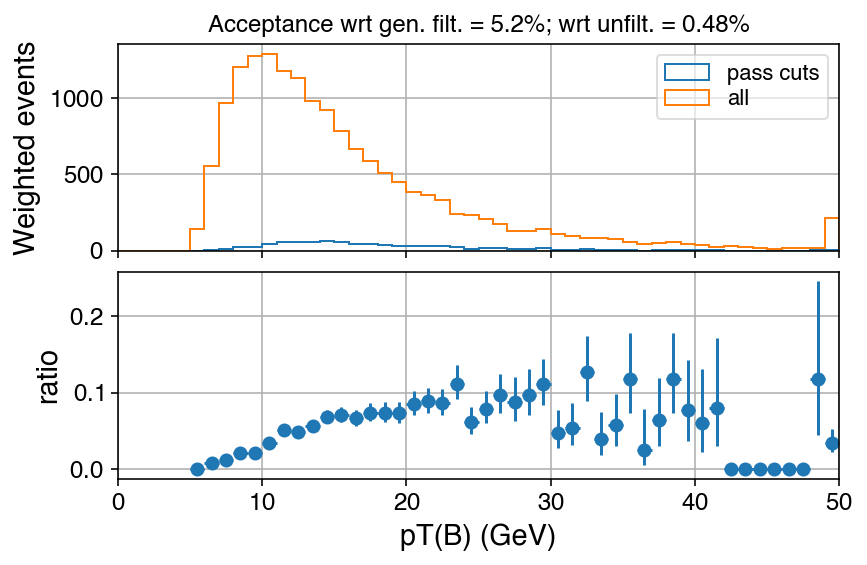

In [32]:
fig, (ax1, ax2) = plt.subplots(2, sharex=True)

h_den = Hist1D(df_gen["BToPhi_bmesonpt"], weights=df_gen["wpt_central"], bins="50,0,50")
h_num = Hist1D(df_reco["BToPhi_bmesonpt"], weights=df_reco["wpt_central"], bins="50,0,50")

h_num.plot(ax=ax1,histtype="step",label="pass cuts")
h_den.plot(ax=ax1,histtype="step",label="all")

h_num.divide(h_den,binomial=True).plot(ax=ax2, show_errors=True)

acceptance = df_reco["wpt_central"].sum()/df_gen["wpt_central"].sum()
acceptance_wrt_unfilt = acceptance*epsgen_central
ax1.set_title("Acceptance wrt gen. filt. = {:.1f}%; wrt unfilt. = {:.2f}%".format(acceptance*100., acceptance_wrt_unfilt*100.))
ax2.set_xlabel("pT(B) (GeV)")
ax1.set_ylabel("Weighted events")
ax2.set_ylabel("ratio")
ax1.grid()
ax2.grid()

In [33]:
# wow, 10.1 ifb is 10.1e3 ipb; how do I deserve a phd?
lumi_pb = 10.1e3

nul = df_nul[np.isclose(df_nul["mass"], mass)].iloc[0][f"ctau = {ctau}mm"]

br_central = 0.5*nul / (acceptance*epsgen_central*lumi_pb*sigma_fonll_central)
br_up = 0.5*nul / (acceptance*epsgen_central*lumi_pb*sigma_fonll_up)
br_down = 0.5*nul / (acceptance*epsgen_central*sigma_fonll_down)

pct_up = 100.*(br_down/br_central-1)
pct_down = 100.*(1-br_up/br_central)
f"UL on BR of {br_central:.3g} +{pct_up:.0f}% -{pct_down:.0f}%"

'UL on BR of 1.81e-09 +1452116% -29%'

In [34]:

acceptance_central = df_reco["wpt_central"].sum()/df_gen["wpt_central"].sum()
acceptance_up = df_reco["wpt_up"].sum()/df_gen["wpt_up"].sum()
acceptance_down = df_reco["wpt_down"].sum()/df_gen["wpt_down"].sum()

br_central = 0.5*nul / (acceptance_central*epsgen_central*lumi_pb*sigma_fonll_central)
br_up = 0.5*nul / (acceptance_up*epsgen_up*lumi_pb*sigma_fonll_central)
br_down = 0.5*nul / (acceptance_down*epsgen_down*lumi_pb*sigma_fonll_central)

pct_up = 100.*(br_up/br_central-1)
pct_down = 100.*(1-br_down/br_central)
f"UL on BR of {br_central:.3g} +{pct_up:.0f}% -{pct_down:.0f}%"

'UL on BR of 1.81e-09 +7% -11%'

In [35]:
df_filteff

,mass,central,down,up
0,0.30,0.1168,0.1279,0.1115
1,0.40,0.1027,0.1124,0.0979
2,0.50,0.0894,0.0979,0.0854
3,0.60,0.0841,0.0921,0.0802
4,0.75,0.0833,0.0912,0.0795
5,1.00,0.0842,0.0923,0.0802
6,1.25,0.0873,0.0955,0.0833
7,1.50,0.0886,0.0970,0.0846
8,2.00,0.0931,0.1018,0.0888
9,2.50,0.1003,0.1099,0.0956


In [47]:

def get_ul_br(mass, ctau):

    smass = str(mass).replace(".","p").replace("p0","")
    fname = f"ntuples/output_mphi{smass}_ctau{ctau}mm.root"
    f = uproot.open(fname)

    df_gen = f["btophitree"].pandas.df()
    df_gen = df_gen[df_gen.eval("BToPhi_nphi==1 and BToPhi_bmesonpt>5 and abs(BToPhi_bmesoneta)<2.8")].reset_index(drop=True)
    df_gen = df_gen.copy()

    epsgen_central = df_filteff[np.isclose(df_filteff["mass"],mass)]["central"].values[0]
    
    df_reco = f["Events"].pandas.df(["pass_all", "mass", "lxy", "BToPhi_nphi", "BToPhi_bmesonpt", "BToPhi_bmesoneta"])
    df_reco = df_reco[df_reco.eval("BToPhi_nphi==1 and BToPhi_bmesonpt>5 and abs(BToPhi_bmesoneta)<2.8")].reset_index(drop=True)
    df_reco = df_reco[df_reco.eval("pass_all")]
    df_reco = df_reco.copy()

    for which in ["central", "up", "down"]:
        df_gen[f"wpt_{which}"] = hists_wpt[which].lookup(df_gen["BToPhi_bmesonpt"])
        df_reco[f"wpt_{which}"] = hists_wpt[which].lookup(df_reco["BToPhi_bmesonpt"])

    acceptance_central = df_reco["wpt_central"].sum()/df_gen["wpt_central"].sum()
    acceptance_wrt_unfilt = acceptance_central*epsgen_central

    # wow, 10.1 ifb is 10.1e3 ipb; how do I deserve a phd?
    lumi_pb = 10.1e3

    nul = df_nul[np.isclose(df_nul["mass"], mass)].iloc[0][f"ctau = {ctau}mm"]

    br_central = 0.5*nul / (acceptance_wrt_unfilt*lumi_pb*sigma_fonll_central)
    br_up = 0.5*nul / (acceptance_wrt_unfilt*lumi_pb*sigma_fonll_up)
    br_down = 0.5*nul / (acceptance_wrt_unfilt*lumi_pb*sigma_fonll_down)

    return dict(mass=mass, ctau=ctau, central=br_central, up=br_up, down=br_down, 
                acceptance=acceptance_wrt_unfilt,
               xsec_pb = sigma_fonll_central,
               xsec_pb_up = sigma_fonll_up,
               xsec_pb_down = sigma_fonll_down,
               )

get_ul_br(2, 10)

{'mass': 2,
 'ctau': 10,
 'central': 1.8062684815805735e-09,
 'up': 1.2832997224904716e-09,
 'down': 2.597121168110446e-09,
 'acceptance': 0.004823252135763208,
 'xsec_pb': 133000000.0,
 'xsec_pb_up': 187200000.0,
 'xsec_pb_down': 92500000.0}

In [45]:
data = []
# masses = [0.5, 0.6, 0.75, 1.25, 1.5, 2, 2.5, 3, 3.5, 4]
masses = [0.5, 0.6, 0.75, 1.25, 1.5, 2, 2.5, 3.5, 4]
ctaus = [1, 10, 100]
for mass in tqdm(masses):
    for ctau in ctaus:
        data.append(get_ul_br(mass, ctau))
df_lims = pd.DataFrame(data)
df_lims

,mass,ctau,central,up,down,acceptance
0,0.50,1,6.546976e-09,4.651431e-09,9.413490e-09,0.004766
1,0.50,10,1.229878e-08,8.737917e-09,1.768365e-08,0.001402
2,0.50,100,7.483549e-08,5.316838e-08,1.076013e-07,0.000216
3,0.60,1,6.062537e-09,4.307251e-09,8.716945e-09,0.005768
4,0.60,10,8.112744e-09,5.763862e-09,1.166481e-08,0.001896
5,0.60,100,5.747831e-08,4.083662e-08,8.264448e-08,0.000244
6,0.75,1,7.382122e-09,5.244777e-09,1.061429e-08,0.006631
7,0.75,10,8.467180e-09,6.015678e-09,1.217443e-08,0.002374
8,0.75,100,4.987172e-08,3.543236e-08,7.170744e-08,0.000355
9,1.25,1,1.369507e-08,9.729936e-09,1.969129e-08,0.007210


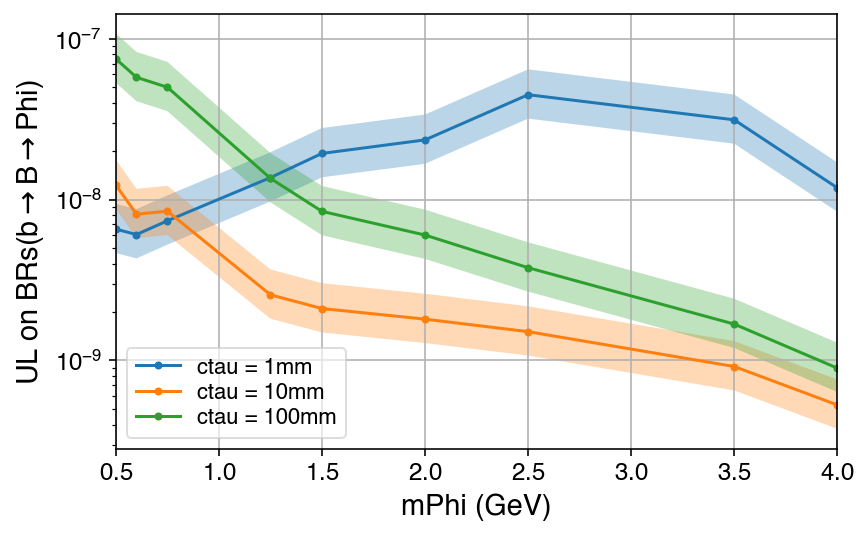

In [50]:
fig, ax = plt.subplots()

for ctau in ctaus:
    df = df_lims[df_lims["ctau"]==ctau]
    xs = df["mass"]
    ys = df["central"]
    ys_up = df["up"]
    ys_down = df["down"]
    
    ax.plot(df["mass"], df["central"], label=f"ctau = {ctau}mm", marker=".")
    ax.fill_between(df["mass"], df["up"], df["down"], alpha=0.3)
    
ax.set_xlabel("mPhi (GeV)")
ax.set_ylabel(r"UL on BRs(b$\rightarrow$B$\rightarrow$Phi)")

ax.legend()
ax.grid()
ax.set_yscale("log")

UL on ($B_0$$\rightarrow$Phi X)
UL on ($B^+$$\rightarrow$Phi X)
UL on ($B_s$$\rightarrow$Phi X)
UL on ($\Lambda_b$$\rightarrow$Phi X)


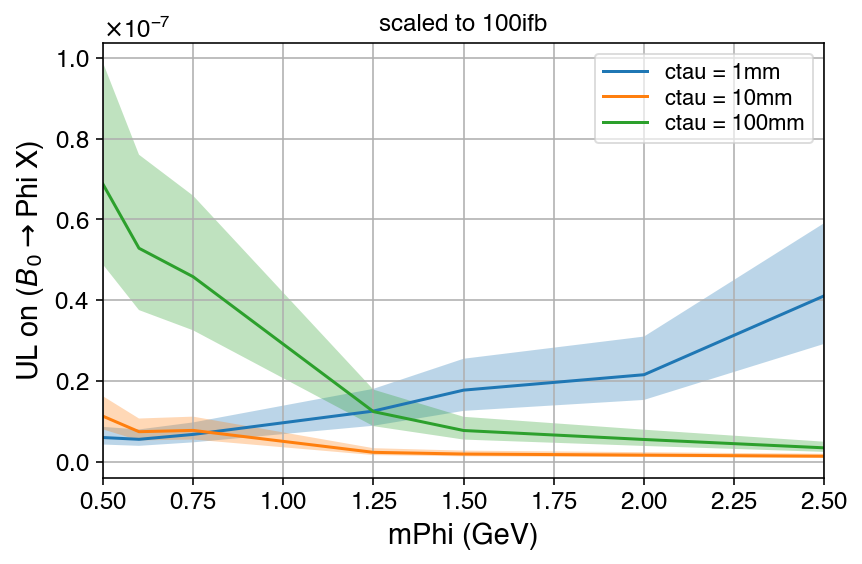

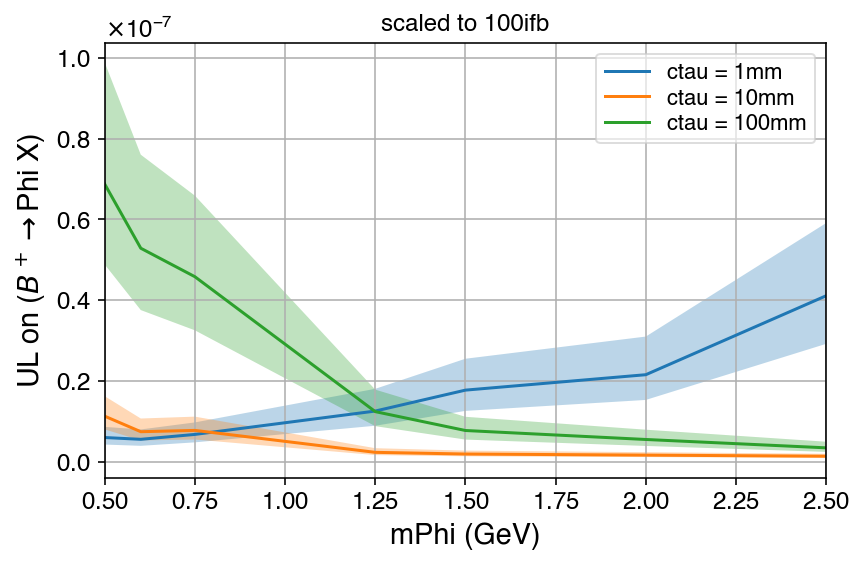

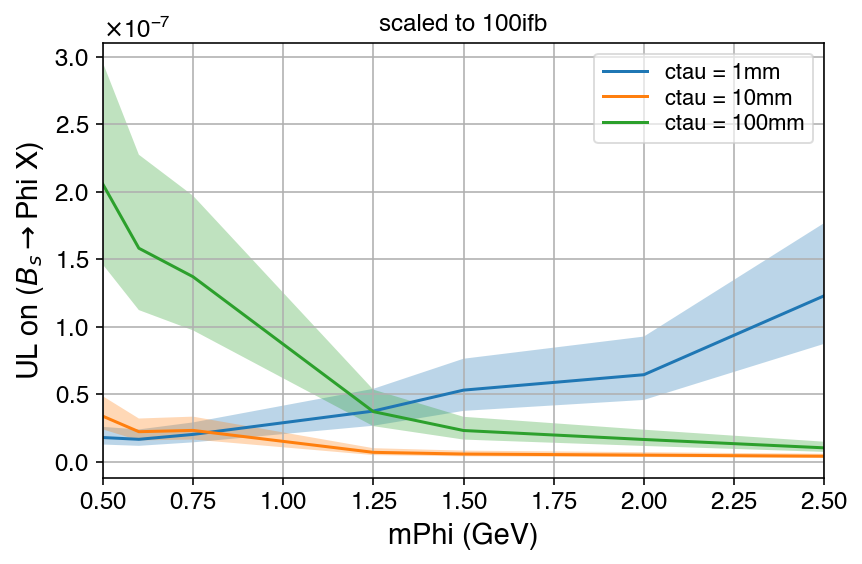

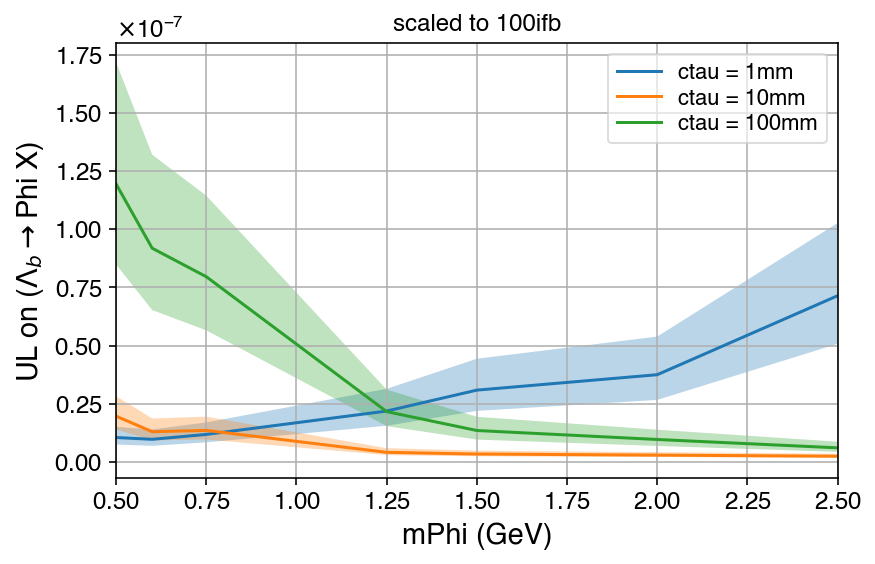

In [60]:
bbrs = {
    r"$B_0$" : 0.344,
    r"$B^+$" : 0.344,
    r"$B_s$" : 0.115,
    r"$\Lambda_b$" : 0.198,
#     r"BR(b$\rightarrow B_0$)" : 0.344,
#     r"BR(b$\rightarrow B^+$)" : 0.344,
#     r"BR(b$\rightarrow B_s$)" : 0.115,
#     r"BR(b$\rightarrow \Lambda_b$)" : 0.198,
}

for brstr,brnum in bbrs.items():
    fig, ax = plt.subplots()
    for ctau in ctaus:
        df = df_lims[df_lims["ctau"]==ctau]
        xs = df["mass"]
        ys = df["central"]
        ys_up = df["up"]
        ys_down = df["down"]
        
        sf = 1./10.**0.5
        sf *= 1./brnum

        ax.plot(df["mass"], sf*df["central"], label=f"ctau = {ctau}mm")
        ax.fill_between(df["mass"], sf*df["up"], sf*df["down"], alpha=0.3)
    ax.set_xlabel("mPhi (GeV)")
    ylabel = r"UL on ({}$\rightarrow$Phi X)".format(brstr)
    print(ylabel)
    ax.set_ylabel(ylabel)
    ax.set_title("scaled to 100ifb")
    ax.legend()
    ax.grid()
    # ax.set_yscale("log")

In [24]:
# df_lims.to_csv("btophi_ul.csv")
# !cat btophi_ul.csv
# !web btophi_ul.csv

,mass,ctau,central,up,down
0,0.5,1,6.543424639105623e-09,4.648907462612435e-09,9.408383535146463e-09
1,0.5,10,1.2291741496394719e-08,8.732914631519752e-09,1.7673531016437812e-08
2,0.5,100,7.479117782189869e-08,5.313689449953273e-08,1.0753758540878407e-07
3,0.6,1,6.063185582615123e-09,4.307711979101557e-09,8.717877648516879e-09
4,0.6,10,8.111740768870967e-09,5.763149157370933e-09,1.1663367808214472e-08
5,0.6,100,5.752095445846135e-08,4.086691743042392e-08,8.27058047889228e-08
6,0.75,1,7.38087861442278e-09,5.243893460033279e-09,1.0612506548305187e-08
7,0.75,10,8.463728043085398e-09,6.013225586166442e-09,1.2169468429517384e-08
8,0.75,100,4.984899684798569e-08,3.541622105118642e-08,7.167477384629294e-08
9,1.25,1,1.367218419962209e-08,9.71367787686826e-09,1.9658383768105275e-08
10,1.25,10,2.5538466015786055e-09,1.8144316133010392e-09,3.6720172757832923e-09
11,1.25,100,1.3519862081433169e-08,9.605457568539591e-09,1.943936926303364e-08
12,1.5,1,1.930778171226532e-08,1.3717601323350895e-08,2.7

In [ ]:
# http://uaf-7.t2.ucsd.edu/~namin/dump/btophi_ul.csv

In [38]:
df_reco = f["Events"].pandas.df(["pass_all", "mass", "lxy", "BToPhi_nphi", "BToPhi_bmesonpt", "BToPhi_bmesoneta", "BToPhi_bmesonid"])
df_reco = df_reco[df_reco.eval("BToPhi_nphi==1 and BToPhi_bmesonpt>5 and abs(BToPhi_bmesoneta)<2.8")].reset_index(drop=True)
df_reco = df_reco[df_reco.eval("pass_all")]
df_reco

,pass_all,mass,lxy,BToPhi_nphi,BToPhi_bmesonpt,BToPhi_bmesoneta,BToPhi_bmesonid
2,True,2.034944,7.799437,1,23.775000,-1.708,521
3,True,1.967048,4.226967,1,10.748000,1.883,-511
4,True,1.940457,1.607117,1,14.411000,-1.655,511
6,True,1.981589,10.437196,1,23.676001,0.419,-521
8,True,1.802204,7.543761,1,15.128000,-1.029,-511
...,...,...,...,...,...,...,...
2015,True,1.978956,3.804831,1,18.694000,-0.071,-521
2016,True,1.979453,0.829148,1,10.503000,2.311,-521
2019,True,2.019785,0.771980,1,20.052999,1.134,521
2021,True,1.994393,0.936907,1,8.310000,1.736,521


In [41]:
df_gen["BToPhi_bmesonid"].abs().value_counts()

511     7771
521     7674
531     1673
5122     623
541        8
Name: BToPhi_bmesonid, dtype: int64

In [55]:
hnum = Hist1D.from_bincounts(df_reco["BToPhi_bmesonid"].abs().value_counts()[[511,521,531,5122]].values, bins=np.arange(5))
hden = Hist1D.from_bincounts(df_gen["BToPhi_bmesonid"].abs().value_counts()[[511,521,531,5122]].values, bins=np.arange(5))
# /df_gen["BToPhi_bmesonid"].abs().value_counts()

<AxesSubplot:>

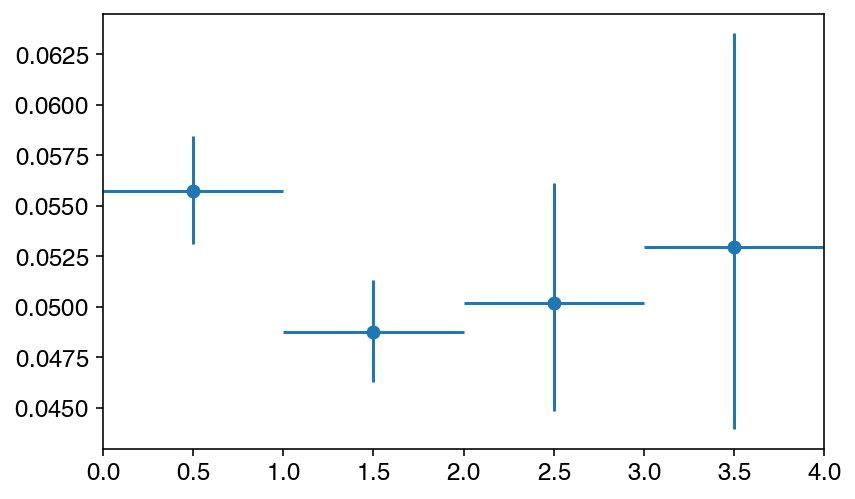

In [59]:
(hnum.divide(hden, binomial=True)).plot(show_errors=True)